In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
import sklearn.linear_model as LinModel
import matplotlib.pylab as plt

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, IsolationForest, ExtraTreesRegressor
from sklearn.svm import SVR 
from sklearn.decomposition import PCA, FastICA, TruncatedSVD
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import KFold, cross_val_score
from scipy.optimize import minimize

plt.style.use('ggplot')

/home/mikhail/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Read & Preparate

In [3]:
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')

#train = train.loc[train['y'] < 200]

train['set'] = 1
test['set']  = 0
data  = pd.concat([train, test])
test_id = test['ID']

data.reset_index(drop=True, inplace=True)

bin_features = data.columns[data.dtypes == int]
cat_features = data.columns[data.dtypes == object]

duplicate_features = ['X205', 'X385', 'X60', 'X44', 'X157', 'X67', 'X39', 'X263', 'X279',
       'X130', 'X299', 'X254', 'X226', 'X326', 'X360', 'X199', 'X262',
       'X214', 'X239', 'X53', 'X71', 'X84', 'X134', 'X147', 'X222', 'X48',
       'X216', 'X62', 'X35', 'X37', 'X119', 'X293', 'X330', 'X76', 'X146',
       'X296', 'X58', 'X364', 'X227', 'X382']

low_std_feat = [ 'X11', 'X93', 'X107',  'X233', 'X235', 'X268', 'X289', 'X290', 'X297', 'X347' ]
low_inique_feat = ['X4']

data.drop(duplicate_features, 1, inplace=True)

In [4]:
cat_features = data.columns[data.dtypes == object]
bin_features    = data.columns[data.dtypes == int ]
bin_features = bin_features.drop(['ID','set'])

In [5]:
dummy_categ = np.array([])
for cat in cat_features:
    dummy = pd.get_dummies(data[cat])
    dummy_name = [cat + '_' + str(x) for x in xrange(dummy.shape[1])]
    dummy.columns = dummy_name
    dummy_categ = np.append(dummy_categ, dummy_name)
    data = pd.concat([data, dummy], axis=1)
data.head()

,ID,X0,X1,X10,X100,X101,X102,X103,X104,X105,...,X8_15,X8_16,X8_17,X8_18,X8_19,X8_20,X8_21,X8_22,X8_23,X8_24
0,0,k,v,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6,k,t,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,az,w,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,9,az,t,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,13,az,v,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
for c in train.columns:
    if train[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(train[c].values) + list(test[c].values))
        train[c] = lbl.transform(list(train[c].values))
        test[c] = lbl.transform(list(test[c].values))
        data[c] = lbl.transform(list(data[c].values))
data.head()

,ID,X0,X1,X10,X100,X101,X102,X103,X104,X105,...,X8_15,X8_16,X8_17,X8_18,X8_19,X8_20,X8_21,X8_22,X8_23,X8_24
0,0,37,23,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6,37,21,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,24,24,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,9,24,21,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,13,24,23,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


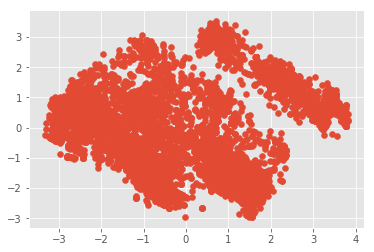

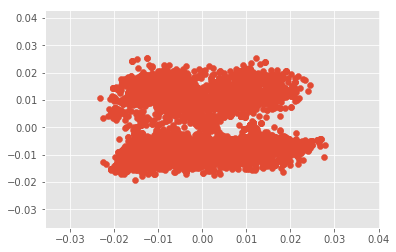

In [7]:
n_comp_pca = 12#12
n_comp_ica = 12#12
n_comp_svd = 2

pca = PCA(n_components = n_comp_pca)
ica = FastICA(n_components=n_comp_ica, max_iter=2000, random_state=2)


pca_comp = pca.fit_transform(data[bin_features])
plt.scatter(pca_comp[:,0], pca_comp[:,1])
plt.show()

ica_comp = ica.fit_transform(data[bin_features])
plt.scatter(ica_comp[:,0], ica_comp[:,1])
plt.show()

#tsvd_comp = tsvd.fit_transform(data[bin_features], random_state = 123)
#plt.scatter(tsvd_comp[:,0], tsvd_comp[:,1])
#plt.show()

pica_name = np.array([])

for i in xrange(n_comp_pca):
    data['PCA_' + str(i+1)] = pca_comp[:,i]
    pica_name = np.append(pica_name, 'PCA_' + str(i+1))
for i in xrange(n_comp_ica):
    data['ICA_' + str(i+1)] = ica_comp[:,i]
    pica_name = np.append(pica_name, 'ICA_' + str(i+1))
#for i in xrange(n_comp_svd):
#    data['SVD_' + str(i+1)] = tsvd_comp[:,i]

In [8]:
mean_y = data.groupby(['X0'])['y'].mean()

group1 = mean_y[ (mean_y <  85) ].index.tolist()
group2 = mean_y[ (mean_y <  99) & (mean_y >= 85)].index.tolist()
group3 = mean_y[ (mean_y < 108) & (mean_y >= 99)].index.tolist()
group4 = mean_y[ (mean_y < 114) & (mean_y >= 108)].index.tolist()
group5 = mean_y[ (mean_y >= 114)].index.tolist()

label1 = data['X0'].isin(group1).values
label2 = data['X0'].isin(group2).values
label3 = data['X0'].isin(group3).values
label4 = data['X0'].isin(group4).values
label5 = data['X0'].isin(group5).values

In [9]:
#data['label'] = np.nan
#for i, label in enumerate([label1, label2, label3, label4, label5]):
#    data['label'].iloc[label] = i
#data['label'].fillna(1, inplace=True)

data['sum_bins'] = data[bin_features].sum(axis=1)

In [10]:
x_train = data.loc[data['set'] == 1].drop(['set','ID','y'], 1)
x_test  = data.loc[data['set'] == 0].drop(['set','ID','y'], 1)
y_train = data.loc[data['set'] == 1, 'y'].values

y_mean = y_train.mean()

x_train1 = x_train.drop(dummy_categ, 1)
x_train2 = x_train.drop(cat_features, 1)
x_test1  = x_test.drop(dummy_categ, 1)
x_test2  = x_test.drop(cat_features, 1)

print x_train1.shape
print x_train2.shape
x_train.head()

(4209, 361)
(4209, 564)


,X0,X1,X10,X100,X101,X102,X103,X104,X105,X106,...,ICA_4,ICA_5,ICA_6,ICA_7,ICA_8,ICA_9,ICA_10,ICA_11,ICA_12,sum_bins
0,37,23,0,0,0,0,0,0,0,0,...,-0.011724,-0.005438,0.009842,-0.021288,-0.000034,-0.008645,0.012018,-0.000356,-0.005683,46
1,37,21,0,1,1,0,0,0,0,0,...,0.006516,-0.009089,0.004881,0.006358,0.006526,0.001437,0.010729,0.001911,-0.012048,47
2,24,24,0,0,1,0,0,0,0,0,...,-0.002742,-0.002287,0.001263,-0.011802,-0.008134,0.000378,-0.004614,-0.049996,-0.002348,63
3,24,21,0,0,1,0,0,0,0,0,...,0.000709,-0.002055,0.002291,-0.001650,0.001201,0.001277,0.001546,-0.050621,-0.002810,54
4,24,23,0,0,1,0,0,0,0,0,...,0.001641,-0.000994,-0.000462,0.000163,0.000049,0.003740,0.000398,-0.057122,0.001490,52


# XGBoost

In [12]:
%%time
xgbst = xgb.XGBRegressor( max_depth = 2, learning_rate = 0.02, n_estimators = 400, 
                         subsample = 0.95, colsample_bytree = 0.95, base_score=y_mean)

cv_score = cross_val_score(xgbst, x_train1, y_train, cv=5, scoring='r2', n_jobs=1)
print cv_score.mean()
print cv_score

0.568868871544
[ 0.62043632  0.45018813  0.59858186  0.54414856  0.63098949]
CPU times: user 1min 40s, sys: 776 ms, total: 1min 41s
Wall time: 27.9 s


# LightGBM

In [13]:
%%time
lgbm = lgb.LGBMRegressor(num_leaves= 5 , max_depth = 3, learning_rate = 0.02, n_estimators = 270, 
                         max_bin=40000, objective='regression_l2', 
                         subsample=0.9, subsample_freq=10, colsample_bytree=0.95 )

cv_score = cross_val_score(lgbm, x_train1, y_train, cv=5, scoring='r2', n_jobs=1)
print cv_score.mean()
print cv_score

0.568633197994
[ 0.61656243  0.44616785  0.59943213  0.54456677  0.63643681]
CPU times: user 23.4 s, sys: 372 ms, total: 23.8 s
Wall time: 6.28 s


# RandomForest

In [14]:
rfr_features = [ 'X0', 'X314', 'X261']
rfr = RandomForestRegressor(n_estimators=120, max_features=1, n_jobs=-1, random_state=432)

cv_score = cross_val_score(rfr, x_train1[rfr_features], y_train, cv=5, scoring='r2', n_jobs=1)
print cv_score.mean()
print cv_score

0.56666335284
[ 0.61480905  0.44141653  0.59285028  0.54726403  0.63697688]


# ExtraTrees

In [15]:
rfr_features = [ 'X0', 'X314', 'X261']
etr = ExtraTreesRegressor(n_estimators = 120, n_jobs=-1, max_features = 1, random_state = 531)

cv_score = cross_val_score(etr, x_train1[rfr_features], y_train, cv=5, scoring='r2', n_jobs=1)
print cv_score.mean()
print cv_score

0.567761784211
[ 0.61390003  0.44149957  0.59913856  0.54687369  0.63739707]


# kNN Regressor

In [16]:
%%time
knn_features = [u'X104', u'X127', u'X136', u'X153', u'X155', u'X156', u'X159', u'X161',
       u'X165', u'X169', u'X17', u'X189', u'X200', u'X204', u'X228', u'X230',
       u'X238', u'X253', u'X26', u'X267', u'X274', u'X276', u'X277', u'X278',
       u'X288', u'X302', u'X306', u'X307', u'X309', u'X311', u'X32', u'X320',
       u'X339', u'X357', u'X359', u'X384', u'X45', u'X47', u'X70', u'X79']

#knn_features = [u'X115', u'X118', u'X126', u'X127', u'X148', u'X153', u'X160', u'X169',
#       u'X17', u'X176', u'X181', u'X184', u'X200', u'X204', u'X232', u'X234',
#       u'X235', u'X238', u'X253', u'X26', u'X267', u'X270', u'X282', u'X290',
#       u'X291', u'X30', u'X302', u'X306', u'X307', u'X309', u'X311', u'X314',
#       u'X316', u'X32', u'X320', u'X335', u'X359', u'X384', u'X47', u'X54',
#       u'X74', u'X79']

knr = KNeighborsRegressor(n_neighbors = 100, weights = 'uniform', metric='minkowski', p = 2, n_jobs = -1 , 
                          algorithm='auto')

cv_score = cross_val_score(knr, x_train[knn_features] , y_train, scoring = 'r2', cv=5, )
print cv_score.mean()
print cv_score

0.566963977581
[ 0.6163305   0.43844335  0.59384514  0.54901666  0.63718423]
CPU times: user 5.39 s, sys: 20 ms, total: 5.41 s
Wall time: 2.07 s


# LinearRegression

In [17]:
%%time
lin = LinModel.Lasso(alpha=0.003, fit_intercept=True, normalize=True)

cv_score = cross_val_score(lin, x_train2, y_train, scoring='r2', cv = 5, n_jobs = -1)

print cv_score.mean()
print cv_score

0.564778835702
[ 0.60381929  0.4381464   0.59695338  0.5509084   0.63406672]
CPU times: user 416 ms, sys: 92 ms, total: 508 ms
Wall time: 9.9 s


# SVR

In [18]:
%%time
svr = SVR(kernel='linear', C = 0.5, epsilon=5.)

cv_score = cross_val_score(svr, x_train2, y_train, scoring='r2', cv = 5, n_jobs=-1)

print cv_score.mean()
print cv_score

0.564753199637
[ 0.6000757   0.43618     0.60220116  0.53939076  0.64591839]
CPU times: user 432 ms, sys: 104 ms, total: 536 ms
Wall time: 27.8 s


# OOF + CV

In [19]:
def OOF(estimator, x_train, y_train, k_folds = 5):
    if type(x_train) is pd.DataFrame:
        x_train = x_train.values
    scores = np.array([])
    y_pred_cv_all = np.zeros(len(x_train))
    kf_split = KFold(k_folds, shuffle=False)
    for train_idx , test_idx in kf_split.split(x_train):   
        estimator.fit(x_train[train_idx], y_train[train_idx])
        y_pred_cv     = estimator.predict(x_train[test_idx])
        y_pred_cv_all[test_idx] = y_pred_cv
        score = r2_score(y_train[test_idx], y_pred_cv)
        scores = np.append(scores, score)   
    return scores, y_pred_cv_all

In [20]:
estimators  = [xgbst, lgbm, knr, lin, svr, rfr, etr]
estim_names = ['xgb', 'lgb', 'knr', 'lin', 'svr', 'rfr', 'etr']
x_trains    = [x_train1, x_train1,
               x_train1[knn_features],
               x_train2, x_train2, 
               x_train1[rfr_features], x_train1[rfr_features]]

n_est = len(estimators)

x_meta = np.empty(shape = (len(y_train), len(estimators)))

k_folds = 5

for i, (estimator, name, x_train_) in enumerate(zip(estimators, estim_names, x_trains)):
    scores_, x_meta_ = OOF(estimator, x_train_, y_train, k_folds)
    x_meta[:,i] = x_meta_
    print name, ' : ' , scores_, 'mean : '  , scores_.mean()

xgb  :  [ 0.62043632  0.45018813  0.59858186  0.54414856  0.63098949] mean :  0.568868871544
lgb  :  [ 0.61656243  0.44616785  0.59943213  0.54456677  0.63643681] mean :  0.568633197994
knr  :  [ 0.6163305   0.43844335  0.59384514  0.54901666  0.63718423] mean :  0.566963977581
lin  :  [ 0.60381929  0.4381464   0.59695338  0.5509084   0.63406672] mean :  0.564778835702
svr  :  [ 0.6000757   0.43618     0.60220116  0.53939076  0.64591839] mean :  0.564753199637
rfr  :  [ 0.61480905  0.44141653  0.59285028  0.54726403  0.63697688] mean :  0.56666335284
etr  :  [ 0.61390003  0.44149957  0.59913856  0.54687369  0.63739707] mean :  0.567761784211


# Experiments

In [278]:
for x_meta_, name in zip(x_meta.T, estim_names):
    print name,': %.5f'%r2_score(y_train, x_meta_)

xgb : 0.56157
lgb : 0.56095
knr : 0.55888
lin : 0.55688
svr : 0.55634
rfr : 0.55878
etr : 0.55981


In [75]:
# find optimal weights
def error(w):
    y = (w*x_meta).sum(1)
    return -r2_score(y_train, y)
w =  minimize(error, x0 = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], bounds = [(0,1) for i in xrange(n_est)])['x']
print sum(w)
print error(w)

1.00039400413
-0.565797732939


In [175]:
# try to use stacking
stacker1 = lgb.LGBMRegressor(num_leaves = 4, max_depth=3, learning_rate=0.01, n_estimators = 450,
                             reg_alpha=0.2, reg_lambda=0.2, subsample_freq = 10)
score1, y_1 = OOF(stacker1, x_meta, y_train, 5)
print score1
print score1.mean()
print r2_score(y_train, y_1)

[ 0.62473599  0.44770987  0.60804823  0.54843121  0.63666844]
0.573118747411
0.565327209761


mean : 0.00569  std : 0.00240


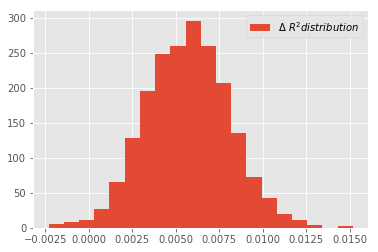

In [327]:
# try compare pairs of models using bootstrap
# y_f, y_s predict of first and second models

delta_error = np.array([])
n_samples = 3300

y_f = (w*x_meta).sum(1)*0.4 + y_1*0.6
y_s = x_meta[:,0]

for i in xrange(2000):
    inds = np.random.randint(0, len(y_train), len(y_train))
    err = r2_score(y_train[inds[:n_samples]], y_f[inds[:n_samples]]) -\
    r2_score(y_train[inds[:n_samples]], y_s[inds[:n_samples]])
    delta_error = np.append(delta_error, err)
print 'mean : %.5f'%delta_error.mean(), ' std : %.5f'%delta_error.std()

plt.hist(delta_error, bins=20, label = '$\Delta\ R^2 distribution$')
plt.legend()
plt.show()

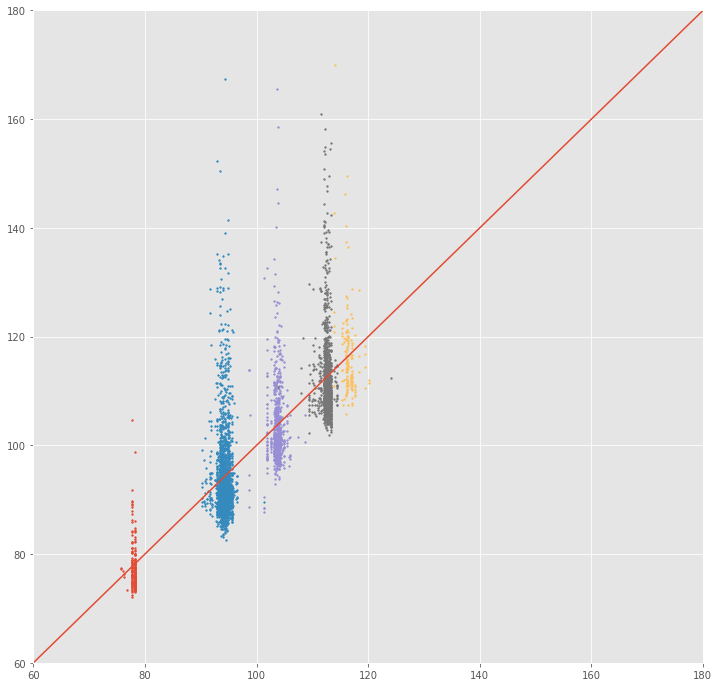

In [109]:
plt.figure(figsize=(12,12))
for label in [label1, label2, label3, label4, label5]:
    plt.scatter(x_meta[label[:len(y_train)],6], y_train[label[:len(y_train)]], s = 3)
plt.plot(np.arange(60,185,5), np.arange(60,185,5))
plt.xlim(60,180)
plt.ylim(60,180)
plt.show()

# Train xgb, lgb, knr, lin, svr, rfr, etr

In [618]:
estimators  = [xgbst, lgbm, knr, lin, svr, rfr, etr]
estim_names = ['xgb', 'lgb', 'knr', 'lin', 'svr', 'rfr', 'etr']
x_trains    = [x_train1, x_train1,
               x_train1[knn_features],
               x_train2, x_train2, 
               x_train1[rfr_features], x_train1[rfr_features]]

x_tests     = [x_test1, x_test1,
               x_test1[knn_features],
               x_test2, x_test2, 
               x_test1[rfr_features], x_test1[rfr_features]]


y_preds = np.empty(shape = (len(y_train), len(estimators)))

for i, (estimator, name, x_train_, x_test_) in enumerate(zip(estimators, estim_names, x_trains, x_tests)):
    estimator.fit(x_train_, y_train)
    y_preds[:,i] = estimator.predict(x_test_)
    print name, ' : ' , 'ok'

xgb  :  ok
lgb  :  ok
knr  :  ok
lin  :  ok
svr  :  ok
rfr  :  ok
etr  :  ok


# Summm

In [ ]:
y_res = (w*y_preds).sum(1)
y_res

# Write result

In [620]:
output = pd.DataFrame({'ID' : test_id, 'y' : y_res}, index=None)
output.to_csv('result_sub.csv', index=None)
output.head(9)

,ID,y
0,1,81.197362
1,2,96.684036
2,3,81.364374
3,4,78.312173
4,5,111.928449
5,8,93.125124
6,10,111.626858
7,11,94.230666
8,12,116.120845
